In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway 
from datetime import datetime
from calendar import monthrange
from calculate_retention import CalculateRetention
import datetime
from scipy import stats
import pingouin as pg
from tqdm.auto import tqdm
import pylab


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

Загрузим данные 

In [754]:
#users_test = pd.read_csv('users_test.csv', sep = ';')
#users_control_1 = pd.read_csv('users_control_1.csv', sep = ';')
#users_control_2 = pd.read_csv('users_control_2.csv', sep = ';')

#tr_test=pd.read_csv('transactions_test.csv', sep = ';')
#tr_control_1=pd.read_csv('transactions_control_1.csv', sep = ';')
#tr_control_2=pd.read_csv('transactions_control_2.csv', sep = ';')


In [3]:
users_test = pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_users_test.csv', sep =';')
users_control_1 = pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_users_control_1.csv', sep =';')
users_control_2 = pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_users_control_2.csv', sep =';')

tr_test=pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_transactions_test.csv', sep =';')
tr_control_1=pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_transactions_control_1.csv', sep =';')
tr_control_2=pd.read_csv('/Users/alisaabdrakhmanova/Desktop/ANALYST/DATA_ANALYSTS/Projects/final_project/project_3_transactions_control_2.csv', sep =';')



Проверим, влияет ли коэффициент привлекательности на решение о покупке платной подписки.

In [4]:
users_test.groupby(['is_premium','attraction_coeff'])\
          .agg({'uid': 'count'}).sort_values(by='uid', ascending=False).head(10)

uid
is_premium attraction_coeff     
1.0        0                  20
           500                 6
           250                 4
           583                 4
           333                 4
           531                 3
           1000                3
           384                 2
           166                 2
           275                 2

In [5]:
users_control_1.groupby(['is_premium', 'attraction_coeff']).agg({'uid': 'count'})\
          .sort_values(by='uid', ascending=False).head(10)

uid
is_premium attraction_coeff     
1.0        0                  24
           1000                7
           200                 5
           375                 5
           333                 4
           250                 4
           666                 4
           600                 3
           500                 3
           363                 3

Посчитаем количество премиум подписчиков в каждой группе, на текущий момент
тестовая  - 157
контрольная_1  - 192
контрольная_2  - 191

In [6]:
users_control_2.groupby('is_premium').agg({'uid': 'count'}),
users_control_1.groupby('is_premium').agg({'uid': 'count'}),
users_test.groupby('is_premium').agg({'uid': 'count'})

,uid
is_premium,
1.0,157


Посчитаем количество  подписчиков в каждой группе,которые когда либо имели статус премиум
тестовая  - 408
контрольная_1  - 436
контрольная_2  - 411

In [7]:
users_test.groupby('was_premium').agg({'uid': 'count'})
users_control_1.groupby('was_premium').agg({'uid': 'count'})
users_control_2.groupby('was_premium').agg({'uid': 'count'})

,uid
was_premium,
1.0,411


Выполним предобработку данных. 
Уберем из датафрейма дубликаты и пустые значения

In [8]:
us_t = users_test.fillna(0)
us_c_1 = users_control_1.fillna(0)
us_c_2 = users_control_2.fillna(0)

In [9]:
us_t = us_t.drop_duplicates()
us_c_1 = us_c_1.drop_duplicates()
us_c_2 = us_c_2.drop_duplicates()

Проверим есть ли пропущенные значения в данных по транзакциям

In [10]:
tr_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [11]:
tr_control_1 

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


Т.к. они есть только в tr_control_1 уберем их

In [12]:
tr_control_1 = tr_control_1.fillna(0)

In [16]:
tr_c1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [14]:
tr_control_2.duplicated().value_counts()

False    323
True       5
dtype: int64

Удалим дубликаты 

In [15]:
tr_t=tr_test.drop_duplicates()
tr_c1=tr_control_1.drop_duplicates()
tr_c2 = tr_control_2.drop_duplicates()

In [17]:
tr_c1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins
376,891466989.0,United States of America,2017-03-11 07:08:00,2017-03-11 07:56:00,6292.0,147.0,autoreply_message,premium_no_trial


In [18]:
tr_c1 = tr_c1.dropna()

Удалим лишние символы '.0' из столбцов uid,revenue, payment_id из tr_c1

In [19]:
tr_c1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
dtype: object

In [20]:
tr_c1 = tr_c1.astype({'uid': 'string'})
tr_c1 = tr_c1.astype({'payment_id': 'string'})

In [21]:
tr_c1['uid'] = tr_c1.uid.apply(lambda x: x[:-2])
tr_c1['payment_id'] = tr_c1.payment_id.apply(lambda x: x[:-2])

Посчитаем количество пользователей в выборках по каждой стране

In [22]:
users_by_country_t = us_t.groupby('country')\
                         .agg({'uid': 'count'})\
                         .sort_values('uid', ascending=False).reset_index().head(10)

In [23]:
users_by_country_c1 = us_c_1 .groupby('country')\
                             .agg({'uid': 'count'})\
                             .sort_values('uid', ascending=False).reset_index().head(10)
users_by_country_c2 = us_c_2.groupby('country')\
                            .agg({'uid': 'count'})\
                            .sort_values('uid', ascending=False).reset_index().head(10)

In [24]:
users_by_country_t

,country,uid
0,United States of America,1450
1,Argentina,396
2,France,359
3,Italy,323
4,Spain,301
5,Chile,272
6,United Arab Emirates,226
7,Germany,209
8,United Kingdom (Great Britain),169
9,Canada,137


<AxesSubplot:xlabel='country', ylabel='uid'>

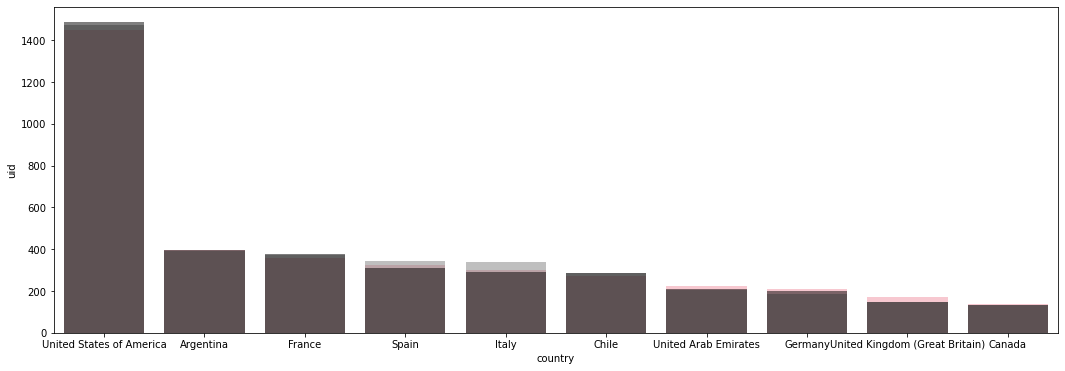

In [25]:
plt.figure(figsize=(18, 6))
sns.barplot(x='country', y='uid', data=users_by_country_t, color='pink')
sns.barplot(x='country', y='uid', data=users_by_country_c1, color='gray', alpha=0.5)
sns.barplot(x='country', y='uid', data=users_by_country_c2, color='black', alpha=0.5)

In [26]:
tr_by_country_t = tr_t.groupby('country').agg({'uid':'count'})\
                        .sort_values('uid',ascending=False).reset_index().head(10)
tr_by_country_c1 = tr_c1.groupby('country').agg({'uid':'count'})\
                        .sort_values('uid',ascending=False).reset_index().head(10)
tr_by_country_c2 = tr_c2.groupby('country').agg({'uid':'count'})\
                        .sort_values('uid',ascending=False).reset_index().head(10)

<AxesSubplot:xlabel='country', ylabel='uid'>

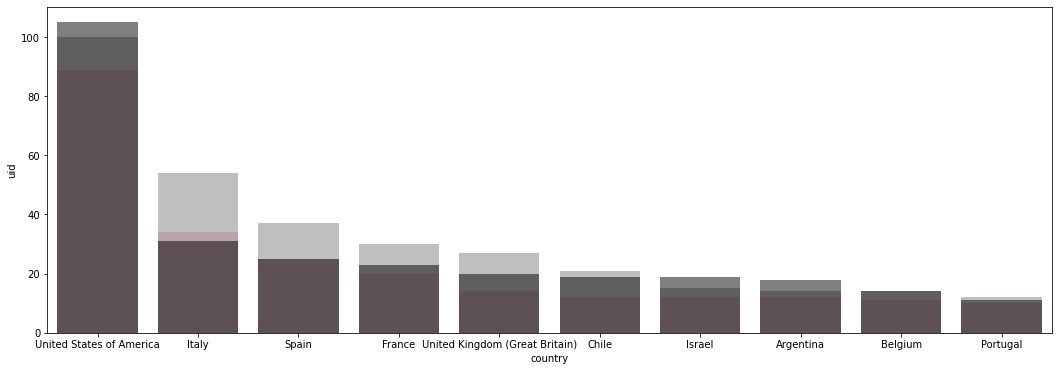

In [27]:
plt.figure(figsize=(18, 6))
sns.barplot(x='country', y='uid', data=tr_by_country_t, color ='pink')
sns.barplot(x='country', y='uid', data=tr_by_country_c1, color ='gray', alpha=0.5)
sns.barplot(x='country', y='uid', data=tr_by_country_c2, color ='black', alpha=0.5)

Посчитаем количество платежных систем, в каждой группе: 
Тестовая - 6
Контрольная_1 - 7
Контрольная_2 - 6

In [28]:
paysyst_t= tr_t.groupby('payment_id').agg({'uid': 'count'}).sort_values('uid', ascending=False).head(10)
paysyst_c1= tr_c1.groupby('payment_id').agg({'uid': 'count'}).sort_values('uid', ascending=False).head(10)
paysyst_c2= tr_c2.groupby('payment_id').agg({'uid': 'count'}).sort_values('uid', ascending=False).head(10)

In [29]:
paysyst_c1

,uid
payment_id,
147,155
19,108
67,35
146,32
68,18
0,6
127,3


In [30]:
tr_c1.query('payment_id=="127"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
3,891367521,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127,sympathy,other_type
200,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,127,coins_popup,other_type
257,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127,sympathy,other_type


2. Добавим столбец с количеством дней, когда пользователь заходил в приложение

In [31]:
us_t.head(10)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0
5,891083133,24,0,0.0,Spain,1,1,16,27,0,0.0,0.0,0
6,891304281,39,0,0.0,France,0,1,36,42,0,0.0,0.0,0
7,892431420,21,909,0.0,Australia,0,1,18,24,11,0.0,0.0,0
8,891085770,28,0,0.0,Italy,"1,2,3,4",1,25,31,1,0.0,0.0,0
9,891142707,30,600,0.0,Israel,"1,2,4,5,6",1,19,33,10,0.0,0.0,0


Переведем столбец с данными о визитах в строковый тип

In [32]:
us_t = us_t.astype({'visit_days': 'string'})

In [33]:
us_c_1 = us_c_1.astype({'visit_days': 'string'})
us_c_2 = us_c_2.astype({'visit_days': 'string'})

In [252]:
#us_t['visits_count']= us_t.visit_days.apply(lambda x: len(x) - x.count(",")- x.count("0")-x.count(' '))

Посчитает длину строки

In [34]:
us_t['count_of_visits'] = us_t.visit_days.apply(lambda x: len(x.split(',')) if x!= 0 else 0)
us_c_1['count_of_visits'] = us_c_1.visit_days.apply(lambda x: len(x.split(',')) if x!= 0 else 0)
us_c_2['count_of_visits'] = us_c_2.visit_days.apply(lambda x: len(x.split(',')) if x!= 0 else 0)

Добавим визуализацию по количеству пользователей и количеству визитов по группам

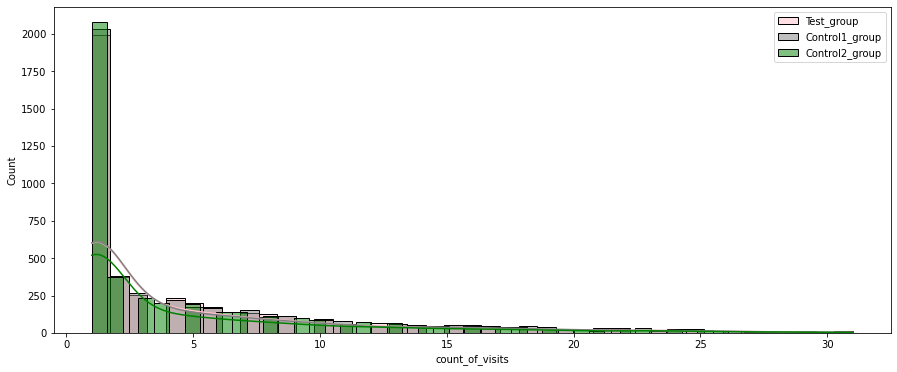

In [41]:

plt.figure(figsize=(15, 6))
sns.histplot(data=us_t, x="count_of_visits", color="pink", label="Test_group", kde=True)
sns.histplot(data=us_c_1, x="count_of_visits", color="gray", label="Control1_group", kde=True)
sns.histplot(data=us_c_2, x="count_of_visits", color="green", label="Control2_group", kde=True)

plt.legend() 
plt.show()

Попробуем найти взаимосвязь между количеством посещений после регистрации и наличием платной подписки в тестовой группе.

In [42]:
сount_of_visits_by_pr_t = us_t.query('is_premium==1.0')\
    .groupby('count_of_visits')\
    .agg({'is_premium': 'count'})\
    .sort_values('is_premium', ascending=False).reset_index().head(10)

In [43]:
сount_of_visits_by_pr_t

,count_of_visits,is_premium
0,1,31
1,2,17
2,5,10
3,9,10
4,3,9
5,7,8
6,8,8
7,4,7
8,13,6
9,10,5


In [44]:
сount_of_visits_by_wp_t =us_t.query('was_premium==1.0')\
    .groupby('count_of_visits')\
    .agg({'was_premium': 'count'})\
    .sort_values('was_premium', ascending=False).reset_index().head(10)

<Figure size 936x432 with 0 Axes>

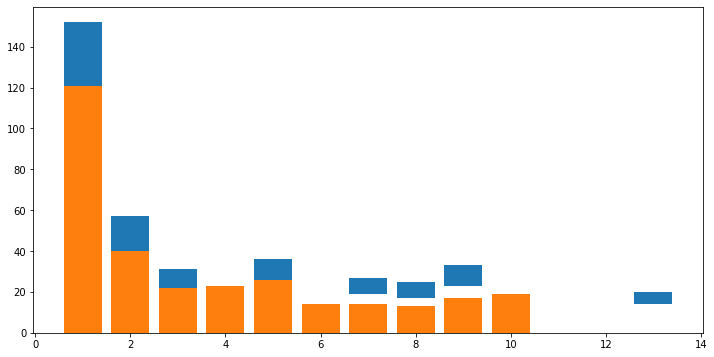

In [45]:
plt.figure(figsize=(13, 6))
x = np.arange(1, 8)
fig, ax = plt.subplots()
ax.bar(сount_of_visits_by_pr_t.count_of_visits, сount_of_visits_by_pr_t.is_premium, bottom=сount_of_visits_by_wp_t.was_premium)
ax.bar(сount_of_visits_by_wp_t.count_of_visits, сount_of_visits_by_wp_t.was_premium)


#ax.set_facecolor('seashell')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
#fig.set_facecolor('floralwhite')
plt.show()

В данном случае мы видим прямую взаимосвязь, с ростом количества заходов в приложение падает количество покупок платной подписки.Аналогично с теми пользователями, которые брали либо пробный период премиум-статуса, либо купленный за деньги когда-то, но не в текущий момент.


Оценим, период совершения транзакций по группам ползователей

In [46]:
tr_t['paid_at'] = pd.to_datetime(tr_t['paid_at'])
tr_c1['paid_at'] = pd.to_datetime(tr_c1['paid_at'])
tr_c2['paid_at'] = pd.to_datetime(tr_c2['paid_at'])

<AxesSubplot:xlabel='paid_at', ylabel='Density'>

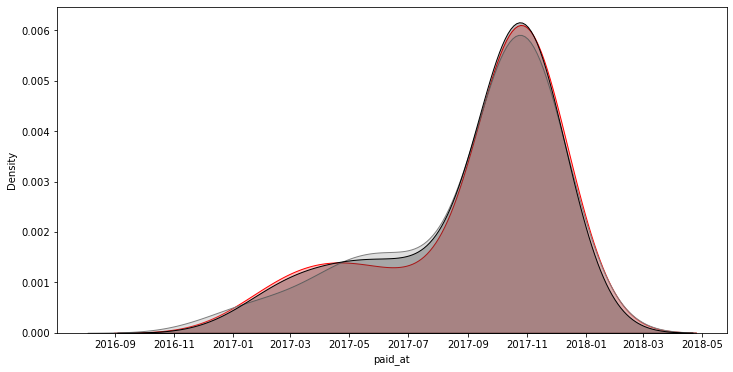

In [47]:
plt.figure(figsize=(12, 6))
sns.kdeplot(tr_t['paid_at'], shade=True, bw_method=0.5, color='red')
sns.kdeplot(tr_c1['paid_at'], shade=True, bw_method=0.5, color='gray')
sns.kdeplot(tr_c2['paid_at'], shade=True, bw_method=0.5, color='black')


Исходя из графика, можно сделать вывод что транзакции в группах совершались примерно в одном временном периоде.

Соединим таблицы с транзакциями

In [53]:
tr_tables = [tr_t, tr_c1, tr_c2]
df_tr = pd.concat(tr_tables)

In [ ]:
Аналогично, поступим с данными по users

In [54]:
us_tables = [us_t, us_c_1, us_c_2]

df_us = pd.concat(us_tables)

Добавим столбцы с названием группы

In [50]:
tr_t['group'] = 'test'
tr_c2['group'] = 'control_2'
tr_c1['group'] = 'control_1'
us_t['group'] = 'test'
us_c_1['group'] = 'control_1'
us_c_2['group'] = 'control_2'

In [55]:
df_tr

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147,trial_vip_popup,trial_premium,test
...,...,...,...,...,...,...,...,...,...
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147,trial_vip_popup,trial_premium,control_2
324,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727.0,147,send_message,trial_premium,control_2
325,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261.0,19,autorefill,coins,control_2
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997.0,147,trial_vip_popup,trial_premium,control_2


Т.к. по условию задачи, был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки (при покупке через две новые платежные системы). Попробуем выявить как она изменилась (возросла либо снизилась) и оценим продуктовые метрики. 

In [56]:
df_tr.query('product_type=="premium_no_trial"')\
     .groupby('group').agg({'revenue': 'mean'})\
     .reset_index().round(2)

,group,revenue
0,control_1,7351.50
1,control_2,6960.83
2,test,10667.18


Посчитаем разницу между значениями  total_revenue и revenue (логичным будет считать, что total_revenue по каждому пользователю равен сумме revenue из таблицы с транзакциями)

In [57]:
revenue_by_trans = df_tr.groupby('uid', as_index=False).agg({'revenue': 'sum'})

In [58]:
df_us = df_us.merge(revenue_by_trans, on='uid', how='left')

In [59]:
df_us = df_us.fillna(0)

Добавим столбец с целевым действием в покупку и с целевым действием в премиум

In [60]:
df_us['diff_rev'] = df_us.total_revenue - df_us.revenue
df_us['cp_purchase'] = df_us.revenue.apply(lambda x: 0 if x<=0 else 1)
df_us['cp_prem'] = df_us.is_premium.apply(lambda x: 0 if x<=0 else 1)

In [61]:
df_us

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,count_of_visits,group,revenue,diff_rev,cp_purchase,cp_prem
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,14,test,0.0,0.0,0,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,1,test,0.0,0.0,0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,20,test,0.0,0.0,0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,12,test,0.0,0.0,0,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,1,test,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,2,control_2,0.0,0.0,0,0
12908,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,13,control_2,0.0,0.0,0,0
12909,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,1,control_2,0.0,0.0,0,0
12910,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,9,control_2,0.0,0.0,0,0


Т.к. средний доход в тестовой группе выше чем в контрольных, можно сделать вывод о повышении цены за подписку в ходе эксперимента. Проверим как повышение стоимости подписки через две новые платежные системы повлияло на продуктовые метрики.

#### Конверсия в покупку статуса 'премиум' в группах

    Посчитаем конверсию в статус премиум (cr_premium) и конверсию в покупку, в целом (сr_purchase)

In [62]:
#Количество пользователей c премиум подпиской и количество пользователей совершивших целевое действие (покупка)
uid_premium = df_us.query('is_premium==1.0')\
                   .groupby('group', as_index= False)\
                   .agg({'uid': 'nunique'})
uid_to_purchase = df_us.query('total_revenue > 0')\
                    .groupby('group', as_index= False)\
                    .agg({'uid': 'nunique'})

Расчет конверсии в премиум подписку и расчет конверсии в покупку

In [63]:
metrics_table = df_us.groupby('group', as_index=False)\
                     .agg({'uid': 'nunique'})
metrics_table['cr_premium'] = (uid_premium.uid / metrics_table.uid).round(3)
metrics_table['cr_to_purchase'] = (uid_to_purchase.uid / metrics_table.uid).round(3)

In [64]:
#Количество пользователей с премиум подпиской
metrics_table['pr_uid'] = uid_premium.uid
metrics_table['cr_percent'] = metrics_table.cr_premium*100

Конверсия в покупку в тестовой группе ниже, чем в контрольных, из чего можно выдвинуть гипотезу о снижении количества покупок в тестовой группе из-за повышения стоимости подписки

    ARPPU (Average revenue per paying user)  число повторных покупок умноженного на  средний чек покупки.

In [65]:
metrics = df_us.query('total_revenue > 0 ')\
                .groupby('group', as_index = False)\
                .agg({'uid':'nunique','total_revenue':'sum'})

In [66]:
metrics_table['arppu'] = (metrics.total_revenue / metrics.uid).round(2)

    ARPU (Average revenue per user)
    Cредний доход с привлечённого пользователя, для расчета возьмем конверсию в покупку в премимум стату

In [67]:
metrics_table['arpu'] = (metrics_table.cr_premium * metrics_table.arppu).round(2)

            LTV (lifetime value) Пожизненная ценность клиента.Рассчитывается как произведение среднего дохода на пользователя (ARPU) и средней продолжительности жизни клиента (Lifetime).

In [68]:
lt_t = df_us.groupby('group', as_index=False)\
            .count_of_visits.mean()

In [69]:
metrics_table['ltv'] = (metrics_table.arpu * lt_t.count_of_visits).round(2)

    Составим таблицу с основными метриками

In [70]:
metrics_table

,group,uid,cr_premium,cr_to_purchase,pr_uid,cr_percent,arppu,arpu,ltv
0,control_1,4340,0.044,0.044,192,4.4,13444.10,591.54,2926.62
1,control_2,4264,0.045,0.044,191,4.5,10269.72,462.14,2202.53
2,test,4308,0.036,0.034,157,3.6,15759.03,567.33,2776.60


    Конверсия в премиум (cr_premium) в тестовой группе ниже чем в обеих контрольных, аналогично с конверсией в покупку, в целом по группам, из чего можно сделать, что имели место факторы влияющие на решение людей о покупке. 
Самый высокий показатель ARPPU в тестовой группе, говорит о том, что в этой группе мы зарабатываем с клиента больше, чем в контрольных (при меньшей конверсии). Значение ARPU в тестовой группе, ниже чем в первой контрольной группе, но выше чем во второй, то есть мы можем сказать что с каждого привлеченного пользователя, в среднем, мы зарабатываем меньше по сравнению с контрольной группой 1. 
    Пожизненная ценность клиента в тестовой группе, ниже чем в первой контрольной, но выше чем во второй, ltv находится в прямой зависимости от показателя ARPU.


In [71]:
df_us

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,count_of_visits,group,revenue,diff_rev,cp_purchase,cp_prem
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,14,test,0.0,0.0,0,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,1,test,0.0,0.0,0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,20,test,0.0,0.0,0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,12,test,0.0,0.0,0,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,1,test,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,2,control_2,0.0,0.0,0,0
12908,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,13,control_2,0.0,0.0,0,0
12909,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,1,control_2,0.0,0.0,0,0
12910,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,9,control_2,0.0,0.0,0,0


    Перед нами поставлена задача оценить, был ли эксперимент успешен целом. Эксперимент состоял в изменении стоимости премиум подписки для новых пользователей из нескольких стран. В ходе анализа, были получены данные, что стоимость подписки была увеличена. Считаю логичным, исследовать факт конверсии в премиум и провести тест на ARPPU, т.к. эта метрика зависит то того насколько часто пользователи совершает покупки и размера среднего чека.

In [ ]:
Необходимо провести AA - тест для оценки работы системы сплитования

  0%|          | 0/1000 [00:00<?, ?it/s]

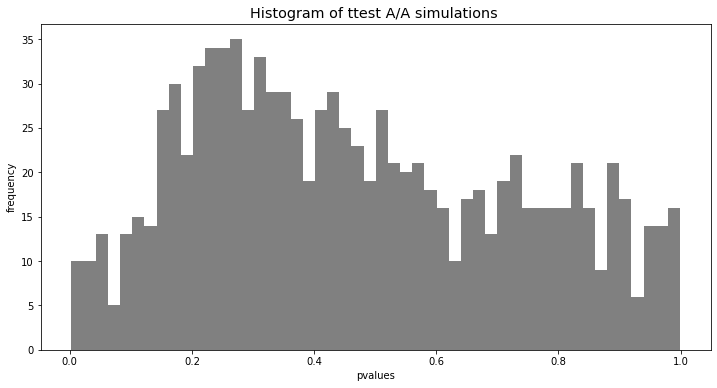

0.026

In [72]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_us[df_us.group=="control_1"]['total_revenue'].sample(n_s, replace=False).values
    s2 = df_us[df_us.group=="control_2"]['total_revenue'].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1]) # сохраняем pvalue

plt.figure(figsize=(12, 6))    
plt.hist(res, color="gray", bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Вывод т.к. условие FPR < a (0.027) соблюдено, то можем считать что сплитовалка работает корректно.

Для выявления зависимости между группами  стоит использовать хи-квадрат. Выдвинем НО - наблюдаемые значения соответствуют ожиданиям (т.е. между ними нет разницы)   и H1 - наблюдения отличны от ожидаемых

Составим таблицу сопряженности

In [73]:
df_us.head(60)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,count_of_visits,group,revenue,diff_rev,cp_purchase,cp_prem
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,14,test,0.0,0.0,0,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,1,test,0.0,0.0,0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,20,test,0.0,0.0,0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,12,test,0.0,0.0,0,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,1,test,0.0,0.0,0,0
5,891083133,24,0,0.0,Spain,1,1,16,27,0,0.0,0.0,0,1,test,0.0,0.0,0,0
6,891304281,39,0,0.0,France,0,1,36,42,0,0.0,0.0,0,1,test,0.0,0.0,0,0
7,892431420,21,909,0.0,Australia,0,1,18,24,11,0.0,0.0,0,1,test,0.0,0.0,0,0
8,891085770,28,0,0.0,Italy,"1,2,3,4",1,25,31,1,0.0,0.0,0,4,test,0.0,0.0,0,0
9,891142707,30,600,0.0,Israel,"1,2,4,5,6",1,19,33,10,0.0,0.0,0,5,test,0.0,0.0,0,0


In [74]:
test_c1_c2 = pd.crosstab(df_us.is_premium, df_us.group)
test_c1 = pd.crosstab(df_us.query('group!="control_2"').is_premium, df_us.query('group!="control_2"').group)
test_c2 = pd.crosstab(df_us.query('group!="control_1"').is_premium, df_us.query('group!="control_1"').group)
test_bye = pd.crosstab(df_us.was_premium, df_us.group)

In [75]:
metrics_table

,group,uid,cr_premium,cr_to_purchase,pr_uid,cr_percent,arppu,arpu,ltv
0,control_1,4340,0.044,0.044,192,4.4,13444.10,591.54,2926.62
1,control_2,4264,0.045,0.044,191,4.5,10269.72,462.14,2202.53
2,test,4308,0.036,0.034,157,3.6,15759.03,567.33,2776.60


In [ ]:
Проведем расчет хи - квадрат

In [76]:
from scipy.stats import chi2_contingency
table = test_c1_c2
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=4.682, p=0.096
Probably independent


Критерий χ2  превышает критическое значение (p-value > 0.05), значит мы  принимаем H0 – между тестовыми группами и числом платящих пользователей нет зависимости, так как наблюдаемые частоты в группах отличаются от ожидаемых.

Можно сделать вывод, что изменение стоимости подписки не привело к статистически значимому изменению конверсии.

In [ ]:
Для проверки результата,проведем дополнительные исследования отдельно по тестовой группе и по одной из контрольных

In [77]:
from scipy.stats import chi2_contingency
table = test_c1
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3.194, p=0.074
Probably independent


In [78]:
from scipy.stats import chi2_contingency
table = test_c2
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3.624, p=0.057
Probably independent


In [ ]:
В обоих случаях, мы принимаем нулевую гипотезу. 

In [ ]:
Хи квадрат- конверсия в покупку

In [79]:
from scipy.stats import chi2_contingency
table = test_bye
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.863, p=0.650
Probably independent


Построим средние с доверительными интервалами

<AxesSubplot:xlabel='group', ylabel='total_revenue'>

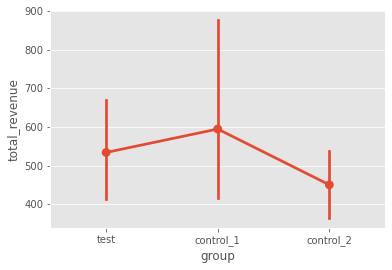

In [80]:
sns.pointplot(x="group", y="total_revenue", data=df_us)

In [ ]:
Из графика можно сделать вывод, о выбросах в группе contol_1 

Проверим наше распределение на нормальность

In [81]:
pg.normality(data=df_us, dv="total_revenue", group="group", method="normaltest")

,W,pval,normal
test,8916.392317,0.0,False
control_1,13980.768501,0.0,False
control_2,7811.263351,0.0,False


In [82]:
test = df_us.query('group=="test"').total_revenue
control_1 = df_us.query('group=="control_1"').total_revenue
control_2 = df_us.query('group=="control_2"').total_revenue

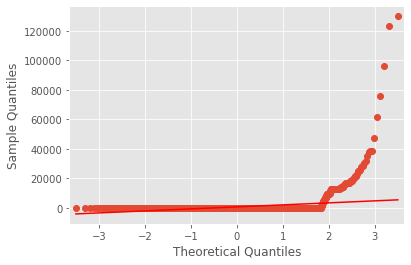

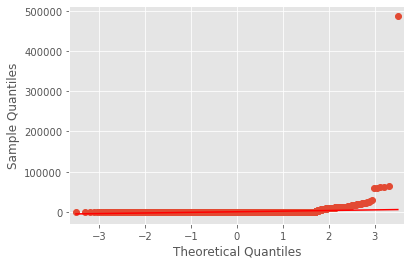

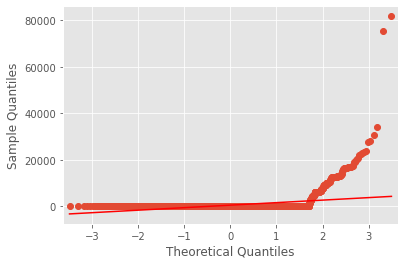

In [83]:
sm.qqplot(test, line="r",)
sm.qqplot(control_1, line="r")
sm.qqplot(control_2, line="r")
plt.show()

In [ ]:
Посчитаем выручку по группам 

In [84]:
df_us.groupby('group').agg({'total_revenue': 'sum'})

,total_revenue
group,
control_1,2581267
control_2,1920438
test,2300818


In [85]:
df_tr.groupby('group').agg({'revenue': 'sum'})

,revenue
group,
control_1,2494804.0
control_2,1907997.0
test,2332226.0


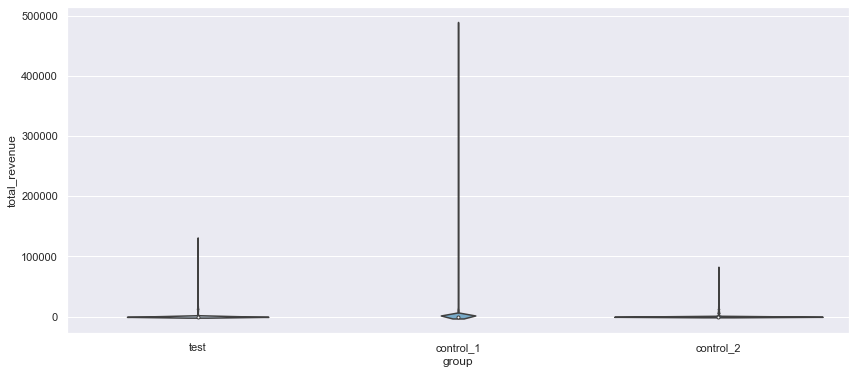

In [86]:
plt.figure(figsize=(14, 6))
sns.set(style="darkgrid")
sns.violinplot(x='group', y='total_revenue', data=df_us, order=["test", "control_1", "control_2"], palette="Blues")
plt.show()

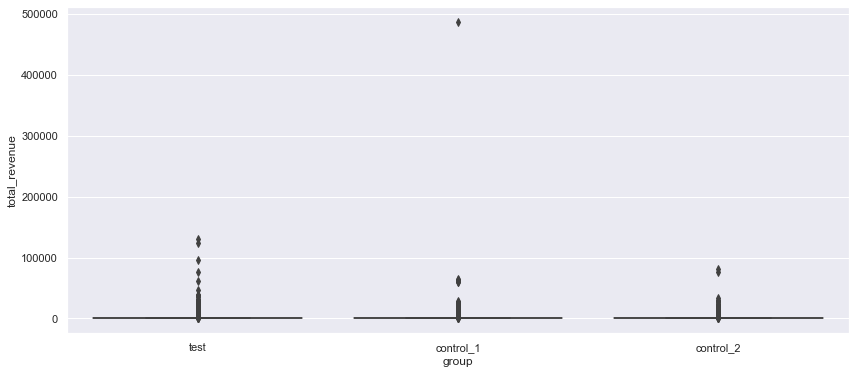

In [87]:
plt.figure(figsize=(14, 6))
sns.set(style="darkgrid")
sns.boxplot(x='group', y='total_revenue', data=df_us, order=["test", "control_1", "control_2"], palette="Blues")
plt.show()

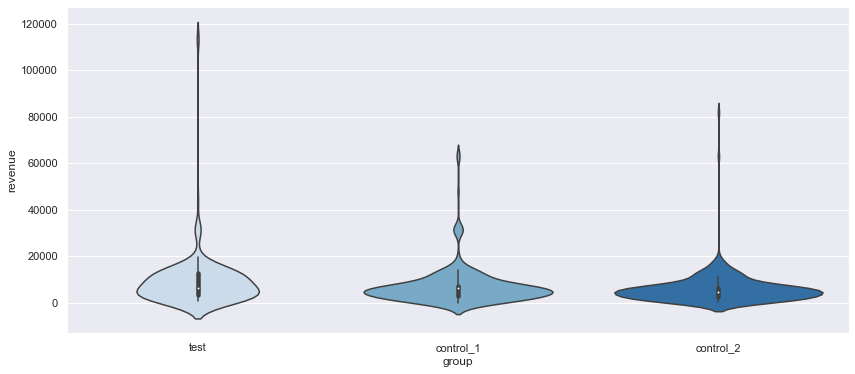

In [88]:
plt.figure(figsize=(14, 6))
sns.violinplot(x='group', y='revenue', data=df_tr, order=["test", "control_1", "control_2"], palette="Blues")
plt.show()

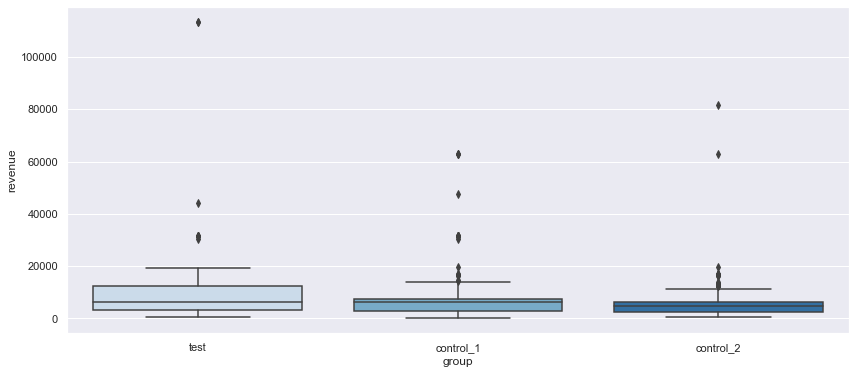

In [89]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='group', y='revenue', data=df_tr, order=["test", "control_1", "control_2"], palette="Blues")
plt.show()

Как видно из графика, в группе control_1, присутствует выброс. Проверим, корректность этих данных. 


In [90]:
df_us.query('total_revenue>450000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,count_of_visits,group,revenue,diff_rev,cp_purchase,cp_prem
5735,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,8,control_1,0.0,486330.0,0,1


Попробуем убрать выброс и проверим как изменились графики

In [91]:
df_us_cl = df_us.query('uid!=892333905')
df_tr_cl = df_tr.query('uid!=892333905')

In [ ]:
#plt.figure(figsize=(14,6))
#sns.set(style="darkgrid")
#sns.violinplot(x='group', y='total_revenue', data=df_us_cl, order=[ "test", "control_1", "control_2"], palette="Blues")
#plt.show()

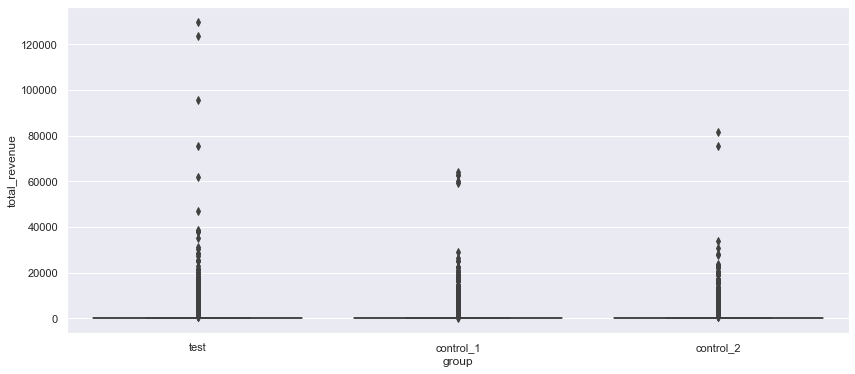

In [93]:
plt.figure(figsize=(14,6))
sns.set(style="darkgrid")
sns.boxplot(x='group', y='total_revenue', data=df_us_cl, order=[ "test", "control_1", "control_2"], palette="Blues")
plt.show()

In [ ]:
#plt.figure(figsize=(14, 6))
#sns.violinplot(x='group', y='revenue', data=df_tr_cl, order=[ "test", "control_1", "control_2"], palette="Blues")
#plt.show()

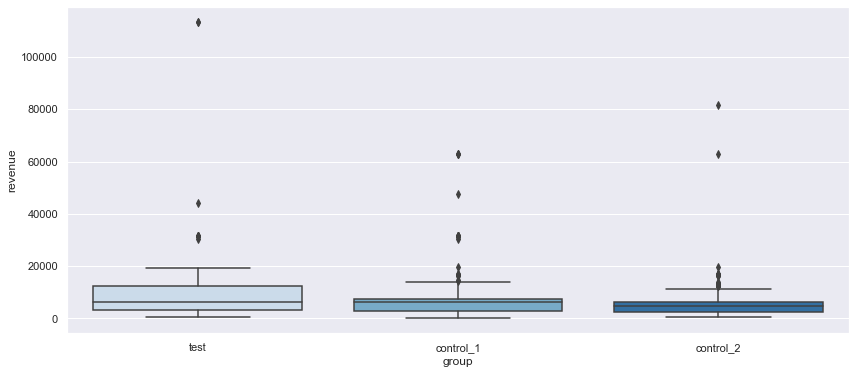

In [95]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='group', y='revenue', data=df_tr_cl, order=[ "test", "control_1", "control_2"], palette="Blues")
plt.show()

Для дальнейших исследований будем использовать очищенные данные

    Основной задачей исследования является оценить успешность эксперимента (изменение стоимости премиум подписки), поэтому следует оценить ARPPU в премиум. 
Т.к. наше распределение не является нормальным, тест на ARPPU в премиум проведем при помощи bootstrap

In [96]:
df_us.query('is_premium>0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,count_of_visits,group,revenue,diff_rev,cp_purchase,cp_prem
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,3,test,12597.0,0.0,1,1
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,9,test,37817.0,0.0,1,1
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580,9,test,21580.0,0.0,1,1
105,892430988,28,181,0.0,United States of America,"1,2",1,25,31,22,1.0,1.0,12727,2,test,12727.0,0.0,1,1
134,891919368,29,250,0.0,France,0,1,26,32,4,1.0,1.0,16536,1,test,16536.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,892186737,30,250,0.0,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732,16,control_2,4732.0,0.0,1,1
12834,891097317,29,1000,0.0,Canada,0,1,26,32,1,1.0,1.0,0,1,control_2,0.0,0.0,0,1
12838,891452592,49,127,0.0,France,"1,2,3,4,5,6,7,8,9,10,11,12",1,39,48,837,1.0,1.0,15626,12,control_2,15626.0,0.0,1,1
12839,891055815,24,0,0.0,Portugal,1,1,21,27,0,1.0,1.0,0,1,control_2,0.0,0.0,0,1


Отберем данные для эксперимента, отдельно по группам:

In [97]:
data_t = df_us_cl.query('total_revenue > 0 and is_premium >0 and group=="test"').total_revenue
data_c1 = df_us_cl.query('total_revenue > 0 and is_premium >0 and group=="control_1"').total_revenue
data_c2 = df_us_cl.query('total_revenue > 0 and is_premium >0 and group=="control_2"').total_revenue

In [98]:
# Применим бутстрап (с np.mean) 
#Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_c2, # числовые значения первой выборки
    data_t, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_c2), len(data_t)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_c2.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_t.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(14,6))
    plt.hist(pd_boot_data[0], bins = 50,color="gray")
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

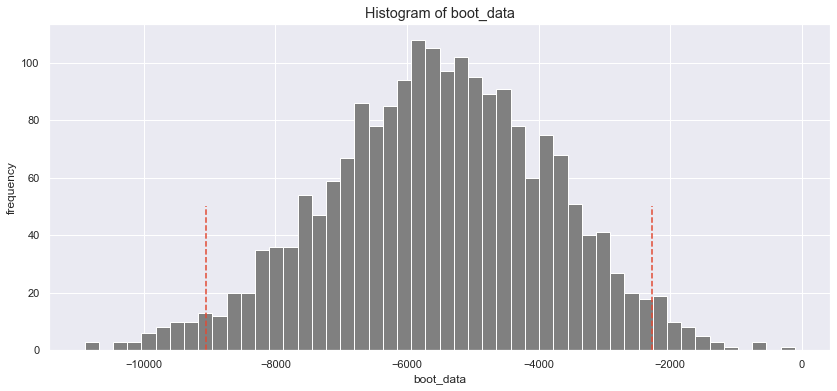

In [99]:
booted_data_c1_t = get_bootstrap(data_c1, data_t, boot_it = 2000)

In [100]:
booted_data_c1_t ["p_value"]

0.0012066873690380427

In [101]:
booted_data_c1_t ["ci"]

,0
0.025,-9049.027083
0.975,-2277.633333


Вывод, доверительный интервал не попадает в 0, p-value < 0.05 отклоняем HO

  0%|          | 0/2000 [00:00<?, ?it/s]

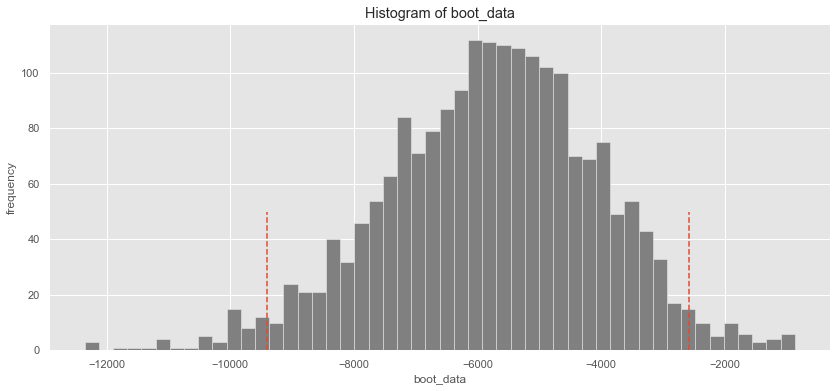

In [102]:
booted_data_c2_t = get_bootstrap(data_c2, data_t, boot_it = 2000)

In [112]:
booted_data_c2_t["p_value"]

0.000911567742678524

In [113]:
booted_data_c2_t["ci"]

,0
0.025,-9403.113758
0.975,-2578.822651


Вывод по группе control_1 test, доверительный интервал не попадает в 0, p-value < 0.05 отклоняем HO
Вывод по группе control_2 test, доверительный интервал не попадает в 0, p-value < 0.05 отклоняем HO

    Вывод Так как мы отклоняем нулевую гипотезу, мы можем говорить о том, что в ходе исследования мы обнаруживаем статистически значимые различия, так как мы оценивали премиум подписку, можно сказать что увеличение стоимости платной подписки положительно влияет на доход

Проверим, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
Необходимо оценить эффект от изменения стоимости премиум подписки,что непосредственно влияет на доход в группах
 мы можем разделить пользователей по следующим признакам
       - страна
       - страница входа
       - тип продукта
       - источник платежа

In [1389]:
#rev_by_countries = df_us.query('total_revenue>0')\
    #.groupby(['group','country'])\
   # .agg({'total_revenue':'sum','is_premium':'sum'})\
   # .sort_values('total_revenue', ascending = False)


In [1392]:
#d3 = rev_by_countries.reset_index()

In [1436]:
#countries_table = rev_by_countries.groupby(['group','country'])\
                   # .agg({'total_revenue':'sum','is_premium':'sum'})

In [ ]:
#Так как изменения были введны в двух новых странах, проверим это на практике. Пересчитаем метрики по каждой стране

In [1354]:
#d2 = countries_table.pivot(index='country', columns='group', values='total_revenue').reset_index()

In [1441]:
#2['total_value']=d2.control_1+d2.control_2+d2.test
#d2.sort_values('total_value',ascending = False).head(10)

Проверим есть ли зависимость по группам пользователей

In [114]:

revenue_by_page = df_tr[['uid', 'group', 'from_page', 'revenue']]

<AxesSubplot:xlabel='group', ylabel='revenue'>

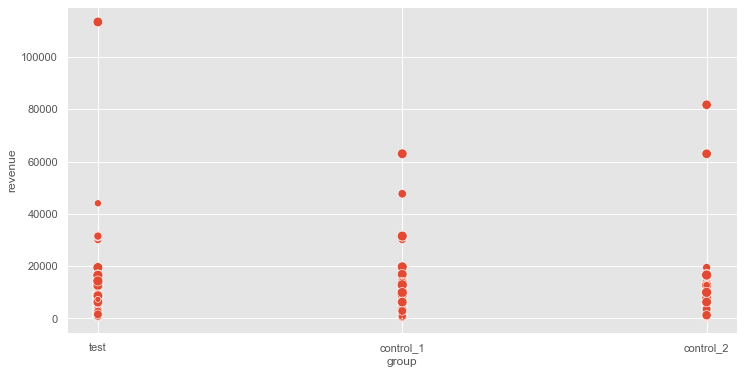

In [115]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=revenue_by_page, x="group", y="revenue", size="from_page", legend=False, sizes=(1, 100))

In [136]:
#plt.figure(figsize=(18, 10))
#sns.pointplot(x="from_page", y="revenue", hue="group", data=revenue_by_page.query('from_page!="0"'), capsize=0.2)

<AxesSubplot:xlabel='from_page', ylabel='revenue'>

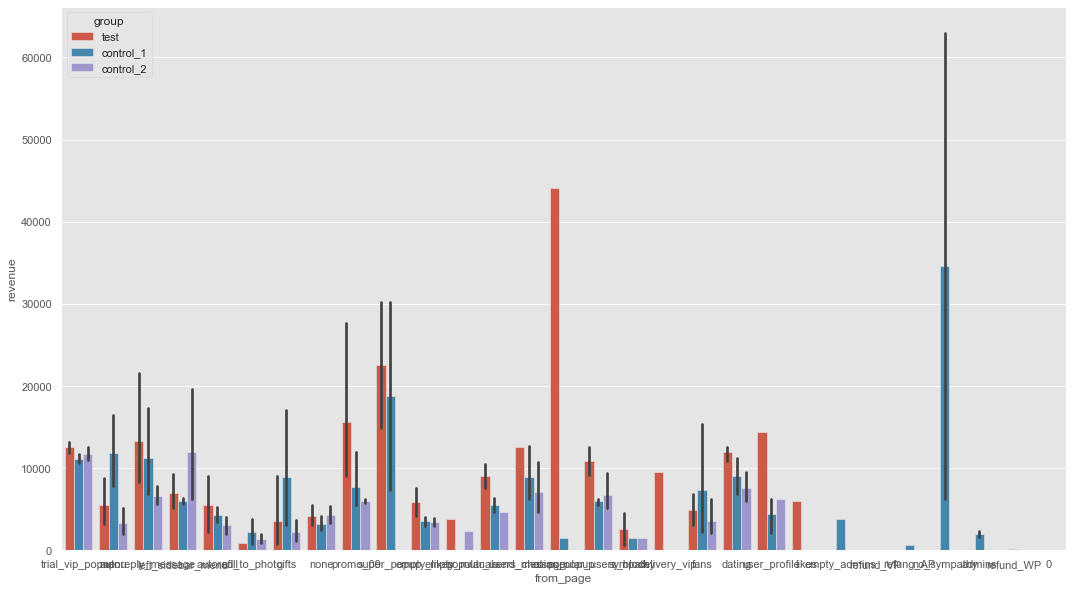

In [119]:
plt.figure(figsize=(18, 10))
sns.barplot(x="from_page", y="revenue", hue="group", data=revenue_by_page.query('from_page!="0"'))

In [141]:
#plt.figure(figsize=(18, 10))
#sns.distplot(x="from_page", data=revenue_by_page, capsize=0.2)

Для данного типа анализа удобно использовать ANOVA

In [126]:
pg.anova(data=revenue_by_page, dv="revenue", between=["group", "from_page"])

/Users/alisaabdrakhmanova/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 27
  warnings.warn('covariance of constraints does not have full '
/Users/alisaabdrakhmanova/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,group,-7.217108e-02,2.0,-3.608554e-02,-5.843120e-10,1.000000,-1.327982e-12
1,from_page,-7.977766e-01,28.0,-2.849202e-02,-4.613546e-10,1.000000,-1.467947e-11
2,group * from_page,9.877369e+08,56.0,1.763816e+07,2.856044e-01,0.593186,1.785040e-02
3,Residual,5.434643e+10,880.0,6.175731e+07,NaN,NaN,NaN


Для фактора group эффект не является значимым
Для фактора from_page эффект не является значимым
Взаимодействие факторов также не является значимым

In [127]:
revenue_by_payment = df_tr[['uid', 'group', 'payment_id', 'revenue']]

In [137]:
#plt.figure(figsize=(18, 10))
#sns.pointplot(x="payment_id", y="revenue", hue="group", data=revenue_by_payment, capsize=0.2)

<AxesSubplot:xlabel='payment_id', ylabel='revenue'>

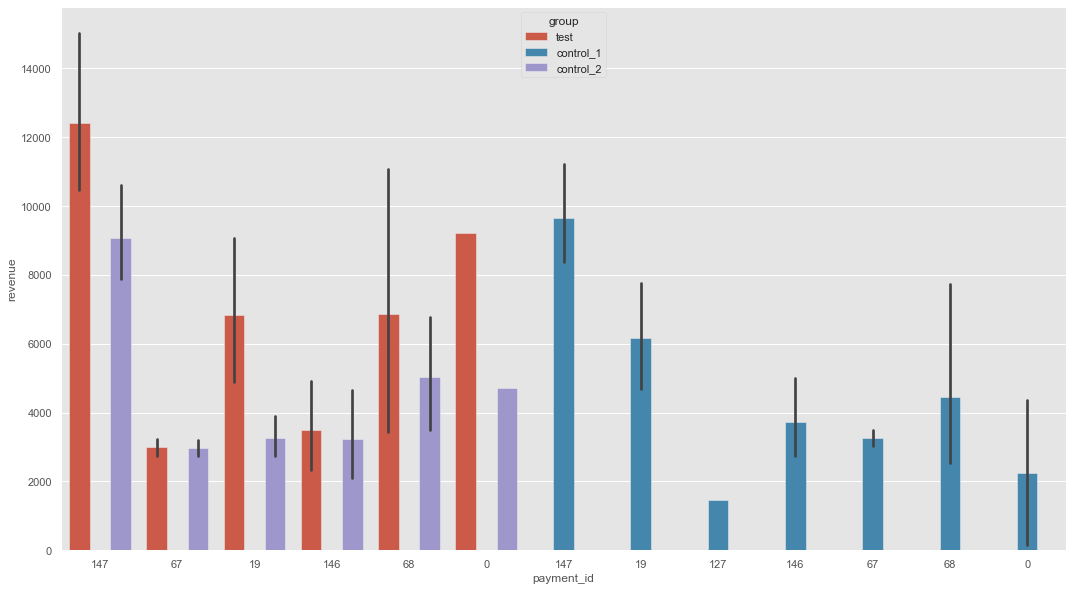

In [129]:
plt.figure(figsize=(18, 10))
sns.barplot(x="payment_id", y="revenue", hue="group", data=revenue_by_payment)

In [130]:
revenue_by_payment = revenue_by_payment.astype({'payment_id': 'int'})

In [131]:
pg.anova(data=revenue_by_payment, dv="revenue", between=["group", "payment_id"])

/Users/alisaabdrakhmanova/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,group,-2.987934e-01,2.0,-1.493967e-01,-2.242604e-09,1.000000,-4.838413e-12
1,payment_id,2.814446e-02,6.0,4.690743e-03,7.041306e-11,1.000000,4.557480e-13
2,group * payment_id,1.197711e+08,12.0,9.980928e+06,1.498244e-01,0.698792,1.935720e-03
3,Residual,6.175443e+10,927.0,6.661750e+07,NaN,NaN,NaN


Для фактора group эффект не является значимым
Для фактора payment_id эффект не является значимым
Взаимодействие факторов также не является значимым

In [132]:
revenue_by_country = df_tr[['uid','group', 'country', 'revenue']]

In [138]:
#plt.figure(figsize=(18,10))
#sns.pointplot(x="country", y="revenue", hue="group", data=revenue_by_country, capsize=0.2)

<AxesSubplot:xlabel='country', ylabel='revenue'>

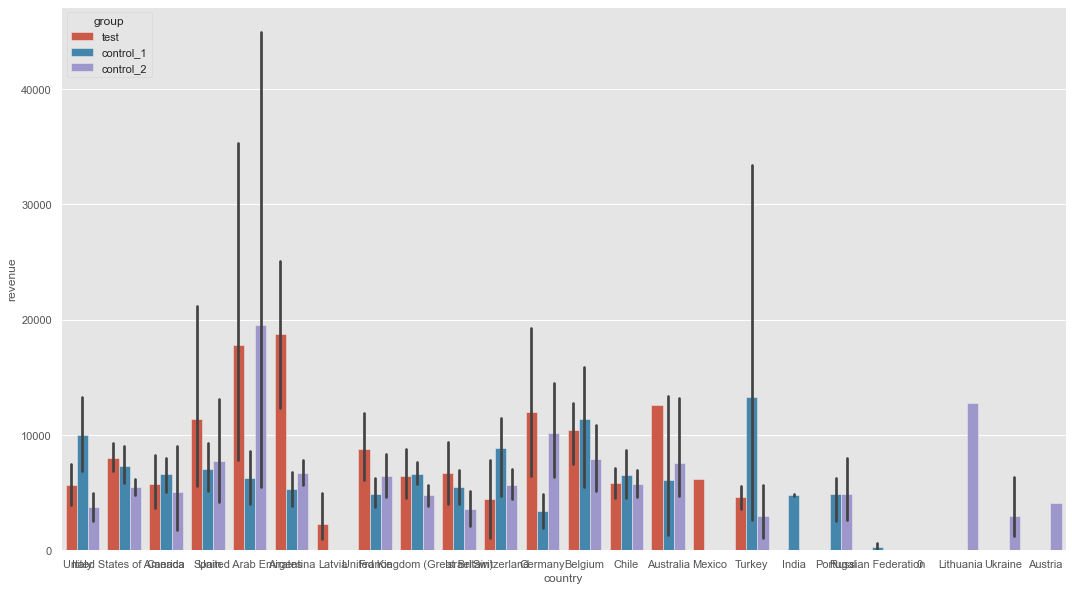

In [134]:
plt.figure(figsize=(18, 10))
sns.barplot(x="country", y="revenue", hue="group", data=revenue_by_country)

In [135]:
pg.anova(data=revenue_by_country, dv="revenue", between=["group", "country"])

/Users/alisaabdrakhmanova/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,group,3.556857e-01,2.0,1.778428e-01,2.484641e-09,1.000000,5.577196e-12
1,country,3.493082e+00,23.0,1.518731e-01,2.121818e-09,1.000000,5.477195e-11
2,group * country,3.143570e+09,46.0,6.833848e+07,9.547563e-01,0.328777,4.697605e-02
3,Residual,6.377501e+10,891.0,7.157689e+07,NaN,NaN,NaN


 - Для фактора group эффект не является значимым
 - Для фактора country эффект не является значимым
 - Взаимодействие факторов также не является значимым

   Общий вывод:  Доказать успешность эксперимента не удалось, мы получили данные об увеличении стоимости премиум подписки, в связи с чем вырос доход в тестовой группе, на фоне снижения конверсии. Только в одном из экспериментов были найдены статистически значимые различия, указывающие на то, что увеличение стоимости платной подписки положительно влияет на доход. Других значимых факторов взаимодействия обнаружено не было